# Práctica 1 - Self-Organising Maps - COLORES
## Preparación de entorno
#### Importar librerías de código

Álvaro Chavarri, Daniel Ojeda, Carlos Vega y Lucía Gálvez

In [1]:
# from __future__ import division

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as patches

%matplotlib inline

#### Dataset que se va a utilizar para el entrenamiento

In [2]:
# Código para obtener el Dataset que se va a usar en el entrenamiento
valor_min = 0
valor_max = 255
valores_color = 3
num_colores = 100
# creamos la matriz
datos = np.random.randint(valor_min, valor_max, (valores_color, num_colores))

## SOM Setup
#### Variables definidas por el alumno

In [3]:
# Inicializa tamaño del mapa de Kohonen, número de iteraciones y learning rate
# Inicializa normalizar_datos dependiendo de si tienes que normalizar los datos o no
lado_mapa = 20
periodo = 10000
learning_rate = 0.02 
normalizar_datos = 'true'

#### A partir de este punto solo hay cálculos. No se introducen más valores "a mano"

In [4]:
# Establece el numero de entradas del mapa y el número de datos que se van a usar para entrenar. 
# Utiliza una función que obtenga automáticamente los valores a partir del Dataset.
num_entradas = len(datos)
num_datos = len(datos[0])

# Calcula el vecindario inicial. Debe ser la mitad del lado del mapa de Kohonen
vecindario_inicial = lado_mapa/2

# Normaliza los datos si fuese necesario dividiendo cada dato por el máximo en la matriz
if normalizar_datos == 'true':
    datosN = (datos-np.amin(datos))/(np.amax(datos)-(np.amin(datos)))
    
# Crea una matriz de pesos con valores random entre 0 y 1. Usa la función random.random de la librería NumPy
m_pesos = np.random.random((lado_mapa, lado_mapa, valores_color))

#### Funciones para entrenar/clasificar

##### Calcular BMU
Esta función encuentra la neurona ganadora, calculando la distancia Euclídea neurona-patrón y guardando las coordenadas en la BMU (bmu_idx) 

In [12]:
# Función para encontrar la BMU
"""
   Encuentra la BMU para un patrón de entrada.
   Entradas: (patrón_de_entrada, matriz_de_pesos, número_de_entradas)
   Salidas:  (bmu, bmu_idx) tupla donde
               bmu: vector de pesos de la neurona ganadora
               bum_idx: coordenadas de la neurona ganadora
"""
def calcular_bmu(patron_entrada, m_pesos, num_entradas):
    #inicializamos la distancia minina
    dMin = np.iinfo(np.int).max
    #recorremos la matriz de pesos
    for x in range (m_pesos.shape[0]): #para x
        for y in range (m_pesos.shape[1]): #para y
            w = m_pesos[x, y] #vector de pesos
            dEuclidea = np.sqrt(np.sum((w - patron_entrada)** 2))
            #np.linalg.norm(x-y) #distancia Euclidea
            if dEuclidea < dMin:
                dMin = dEuclidea
                bmu_idx = np.array([x, y])
    #vector de pesos de la neurona ganadora
    bmu = m_pesos[bmu_idx[0], bmu_idx[1]]
    return (bmu, bmu_idx)


##### Variación learning rate
Esta función calcula eta para la i-ésima iteración

In [6]:
# Función para calcular el descenso del coeficiente de aprendizaje (eta)
"""
   Calcula el Learning Rate (eta) que corresponde a la i-ésima presentación.
   Entradas: (learning_rate_inicial, iteracion, período)
   Salidas:  learning_rate para la iteración i

"""
def variacion_learning_rate(learning_rate, i, periodo):
    learning_rateV = learning_rate * (1-(i/periodo))
    return learning_rateV

##### Variación vecindario
Esta función calcula el desdenso del vecindario

In [7]:
# Función para calcular el descenso del vecindario (v)
"""
   Calcula el vecindario  (v) que corresponde a la i-ésima presentación.
   Entradas: (vecindario_inicial, iteracion, período)
   Salidas:  lvecindario para la iteración i

"""
def variacion_vecindario(vecindario_inicial, i, periodo):
    lvecindario = 1 + vecindario_inicial * (1-(i/periodo))
    return lvecindario

##### Decay
Esta función calcula eta en función de la distancia a la BMU

In [8]:
# Función para calcular el descenso del coeficiente de aprendizaje (eta) en función de la distancia a la BMU
"""
   Calcula la amortiguación de eta en función de la distancia en el mapa entre una neurona y la BMU.
   Entradas: (distancia_BMU, vecindario_actual)
   Salidas:  amortiguación para la iteración

"""
def decay(distancia_BMU, vecindario_actual):
    return np.exp(-distancia_BMU**2 / (2*vecindario_actual**2))

#### Funciones para dibujar la salida de la red

Esta función nos permite pintar la matriz de los valores con los colores RGB

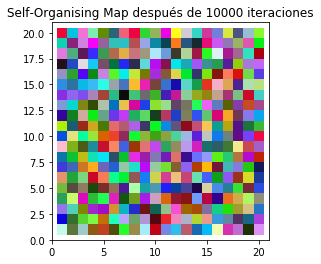

In [9]:
# Función para pintar una matriz de valores como colores RGB
def pintar_mapa(matriz_valores):
    fig = plt.figure()
    
    # Establece ejes
    ax = fig.add_subplot(111, aspect='equal')
    ax.set_xlim((0, m_pesos.shape[0]+1))
    ax.set_ylim((0, m_pesos.shape[1]+1))
    ax.set_title('Self-Organising Map después de %d iteraciones' % periodo)

    # Dibuja los rectángulos de color RGB
    for x in range(1, matriz_valores.shape[0] + 1):
        for y in range(1, matriz_valores.shape[1] + 1):
            ax.add_patch(patches.Rectangle((x-0.5, y-0.5), 1, 1,
                         facecolor=matriz_valores[x-1,y-1,:],
                         edgecolor='none'))
    plt.show()
    
pintar_mapa(m_pesos)

## SOM Entrenamiento

#### Creación del bucle para entrenar la red

In [13]:
# Entrena la red con el dataset de entrenamiento
for i in range(periodo):
    if i % 100 == 0: #cada 100 iteraciones imprimimos el número correspondiente
        print('Iteración: ', i)
        #patrón de entrada escogido al azar y convertido al formato de m_pesos
        patron_entrada = datosN[np.random.randint(datos.shape[0])] 
        #buscamos la BMU
        bmu, bmu_idx = calcular_bmu(patron_entrada, m_pesos, num_entradas)
        #calculamos eta y el vecindario correspondientes a la iteración i
        eta = variacion_learning_rate(learning_rate, i, periodo)
        v = variacion_vecindario(vecindario_inicial, i, periodo)

        #actualizamos el vector de pesos y así nos acercamos al patrón
        for x in range(lado_mapa):
            for y in range(lado_mapa):
                w = m_pesos[x, y] #actualizamos el vector de pesos
                #calculamos la distancia euclídea para cada neurona y acercarnos a la correspondiente
                distEuclidea = np.sqrt(np.sum((w - bmu_idx)** 2))
                #np.linalg.norm(x-y)
                if distEuclidea <= vecindario_inicial: #si la distancia euclidea es menor o igual que el vecindario
                    #calculamos la amortigüación 
                    amortiguacion = decay(distEuclidea, v)
                    #actualizamos el vector de pesos de la neurona
                    m_pesos[x, y] = w + eta * amortiguacion * (patron_entrada - w)

m_pesos

Iteración:  0


ValueError: operands could not be broadcast together with shapes (3,) (100,) 

Pintamos la matriz de pesos con la función definida anteriormente 'pintar_mapa()'

In [ ]:
pintar_mapa(m_pesos)

## SOM Clasificación

### Clasifica los patrones de entrenamiento con la matriz de pesos recién entrenada

#### Definimos e inicializamos las tres matrices
##### Mapa de Clasificación: mClasificacion 
Es una matriz con las mismas dimensiones que m_pesos y guarda en cada neurona el último patron clasificado
##### Mapa de Activación: mActivacion
Es una matriz bidimensional que guarda el número de patrones reconocido por  cada neurona
##### Mapa de Distancias: mDistancias
Es una matriz bidimensional que guarda las neuronas con activación>0

In [14]:
mClasificacion = np.zeros((lado_mapa, lado_mapa, valores_color))                          
mActivacion = np.zeros((lado_mapa, lado_mapa))
mDistancias = np.zeros((lado_mapa, lado_mapa))
distanciaEuclidea = 0

#### Recorremos todo el dataset de entrenamiento

##### Imprimimos las coordenadas x e y de la BMU para cada patrón de prueba

In [15]:
for i in range (0, num_colores):
    bmu, bmu_idx = calcular_bmu(datosN[i], m_pesos, num_entradas)
    #actualizamos el mapa de clasificación, añadiendo el patrón en la neurona que lo ha reconocido
    mClasificacion[bmu_idx[0], bmu_idx[1]] = datosN[i]
    #actualizamos el mapa de activación, +1 en las activaciones
    mActivacion[bmu_idx[0], bmu_idx[1]] =+ 1
    distanciaEuclidea = np.linalg.norm(x-y) #calculamos la distancia euclidea
    mDistancias[bmu_idx[0], bmu_idx[1]] =+ distanciaEuclidea
    print('Coordenadas BMU:', datosN[i])
    print('X = ', bmu_idx[0])
    print('Y = ', bmu_idx[1])   
    

ValueError: operands could not be broadcast together with shapes (3,) (100,) 

##### Calculamos los mapas de clasificación, activación, y distancias

Mapa de Clasificación


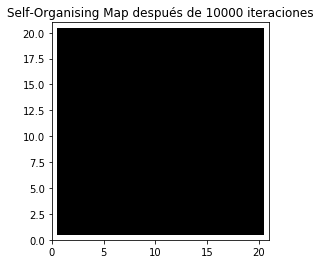


Mapa de Activación


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

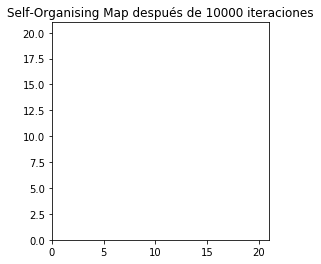

In [18]:
print('Mapa de Clasificación')
pintar_mapa(mClasificacion)
print('\nMapa de Activación')
pintar_mapa(mActivacion)
print('\nMapa de Distancias')
pintar_mapa(mDistancias)

##### Calculamos el número de clases

In [ ]:
num_clases = np.count_nonzero(mActivacion)
print('Número de clases: ', num_clases)

##### Calculamos el Error de Cuantificación y el Error Topológico del mapa

In [19]:
#error de cuantificación
eCuantificacion = (np.sum(mDistancias))/(np.sum(mActivacion))
print('Error de Cuantificación: ', eCuantificacion)


Error de Cuantificación:  nan


C:\Users\luga_\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


In [16]:
#error topológico
def calculate_topographical_error(patron_entrada, m_pesos, num_entradas):
    bmu, bmu_idx = np.argsort(som.get_surface_state(), axis=1)[:,:2]

    neighbors=list(map(lambda t:get_neighbors_from_index(t, n_rows, n_columns), bmus_1st_and_2nd[:,0]))

    e_t=1-np.mean([second in neighs for (second,neighs) in zip(bmus_1st_and_2nd[:,1], neighbors)])
    return(e_t)

## SOM Prueba

In [ ]:
# Clasifica nuevos patrones

